In [1]:
#essential libraries and components
import cv2
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf

from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras import optimizers
from keras.layers import Dropout

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
# assigns file paths for images of broken and full grains to the variables broken and full.
broken='Broken_grain/broken_grain_1.jpg'
full='Full_grain/full_grain_4.jpg'

In [3]:
#takes an input image, crops and resizes it to a specified size, and returns the resulting image.
def crop_resize_img(img):
    ht, wd= img.shape

    ww = 300
    hh = 300
    color = 0
    result = np.full((hh,ww), color, dtype=np.uint8)

    xx = (ww - wd) // 2
    yy = (hh - ht) // 2

    result[yy:yy+ht, xx:xx+wd] = img

    final =cv2.resize(result, (50,50))
    
    return final

In [4]:
#processes a grayscale image using adaptive thresholding, erosion, and contour detection
def pre_process_And_Count(image_path, output_path):
    input_rice = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    output_adapthresh = cv2.adaptiveThreshold (input_rice, 255.0, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 51, -20.0)

    cv2.imwrite('rice_adapthresh.png', output_adapthresh)

    kernel = np.ones((5,5),np.uint8)
    output_erosion = cv2.erode(output_adapthresh, kernel)

    cv2.imwrite('rice_erosion.png', output_erosion)

    contours, hierarchy = cv2.findContours(output_erosion, cv2.RETR_EXTERNAL,  cv2.CHAIN_APPROX_SIMPLE)
    output_contour = cv2.cvtColor(input_rice, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(output_contour, contours, -1, (0, 0, 255), 2)
    print("Number of detected contours", len(contours))
    cv2.imwrite('rice_contours.png', output_contour)
    k=1
    temp = 0.70 * len(contours)
    for i in contours:
        x, y, width, height = cv2.boundingRect(i)
        roi = output_erosion[y:y+height, x:x+width]
        roi=crop_resize_img(roi)
        path  = ''
        if output_path !='mixed/mixed_':
            if k<temp:
                path = 'dataset/train/'+output_path

            else:
                path = 'dataset/test/'+output_path
        else:
            path = output_path
        cv2.imwrite(path+str(k)+".png", roi)
        k+=1


In [5]:
#defines a function that creates a directory at the specified path if it doesn't already exist.
import os
def create_directory(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [6]:
create_directory('dataset')

In [7]:
create_directory('dataset/train')

In [8]:
create_directory('dataset/test')

In [9]:
create_directory('dataset/train/full_rice')

In [10]:
create_directory('dataset/test/full_rice')

In [11]:
create_directory('dataset/train/broken_rice')

In [12]:
create_directory('dataset/test/broken_rice')

In [13]:
pre_process_And_Count(full, 'full_rice/full_')

Number of detected contours 613


In [14]:
pre_process_And_Count(broken, 'broken_rice/broken_')

Number of detected contours 650


In [15]:
#configures data generators for training and validation using images from specific directories 
image_size = (50,50)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    "dataset/train",
    target_size=(50,50),
    batch_size=32,
    class_mode='binary',
    color_mode='grayscale'
)


validation_generator = test_datagen.flow_from_directory(
    "dataset/test",
    target_size=(50, 50),
    batch_size=32,
    class_mode='binary',
    color_mode='grayscale'
)


Found 883 images belonging to 2 classes.
Found 380 images belonging to 2 classes.


In [16]:
train_generator.class_indices

{'broken_rice': 0, 'full_rice': 1}

In [17]:
a, b = next(train_generator)
a.shape

(32, 50, 50, 1)

In [18]:
img_width = 50
img_height = 50

if K.image_data_format() == 'channels_first':
    input_shape = (1, img_width, img_height)
else:
    input_shape = (img_width, img_height, 1)
    
input_shape

(50, 50, 1)

In [19]:
model = Sequential()
model.add(Conv2D(64, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten()) 
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))

import keras
from keras import optimizers
model.compile(loss='binary_crossentropy', 
              optimizer=keras.optimizers.Adam(lr=.0001),
              metrics=['accuracy'])

hist = model.fit_generator(
    train_generator,
    steps_per_epoch=10,
    epochs=200,
    validation_data=validation_generator,
    validation_steps=2)

Epoch 1/200


C:\Users\Lenovo\anaconda3\Lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_19312\1129280634.py:22: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(


10/10 [==============================] - 2s 132ms/step - loss: 0.6865 - accuracy: 0.6000 - val_loss: 0.6678 - val_accuracy: 0.7344
Epoch 2/200
10/10 [==============================] - 1s 101ms/step - loss: 0.6644 - accuracy: 0.6562 - val_loss: 0.6522 - val_accuracy: 0.6094
Epoch 3/200
10/10 [==============================] - 1s 97ms/step - loss: 0.6653 - accuracy: 0.6156 - val_loss: 0.6354 - val_accuracy: 0.6875
Epoch 4/200
10/10 [==============================] - 1s 100ms/step - loss: 0.6558 - accuracy: 0.6406 - val_loss: 0.5997 - val_accuracy: 0.8281
Epoch 5/200
10/10 [==============================] - 1s 91ms/step - loss: 0.6471 - accuracy: 0.6612 - val_loss: 0.6444 - val_accuracy: 0.6719
Epoch 6/200
10/10 [==============================] - 1s 97ms/step - loss: 0.6598 - accuracy: 0.5938 - val_loss: 0.6212 - val_accuracy: 0.6562
Epoch 7/200
10/10 [==============================] - 1s 95ms/step - loss: 0.6498 - accuracy: 0.5813 - val_loss: 0.6648 - val_accuracy: 0.5625
Epoch 8/200
10/

10/10 [==============================] - 1s 106ms/step - loss: 0.4447 - accuracy: 0.8094 - val_loss: 0.4853 - val_accuracy: 0.7656
Epoch 59/200
10/10 [==============================] - 1s 116ms/step - loss: 0.4470 - accuracy: 0.8062 - val_loss: 0.5437 - val_accuracy: 0.7812
Epoch 60/200
10/10 [==============================] - 1s 119ms/step - loss: 0.4627 - accuracy: 0.7969 - val_loss: 0.5126 - val_accuracy: 0.7969
Epoch 61/200
10/10 [==============================] - 1s 107ms/step - loss: 0.4563 - accuracy: 0.7875 - val_loss: 0.6079 - val_accuracy: 0.7031
Epoch 62/200
10/10 [==============================] - 1s 103ms/step - loss: 0.4695 - accuracy: 0.7622 - val_loss: 0.6399 - val_accuracy: 0.6875
Epoch 63/200
10/10 [==============================] - 1s 104ms/step - loss: 0.4843 - accuracy: 0.7720 - val_loss: 0.4979 - val_accuracy: 0.7500
Epoch 64/200
10/10 [==============================] - 1s 110ms/step - loss: 0.4986 - accuracy: 0.7752 - val_loss: 0.7792 - val_accuracy: 0.5938
Epoch

Epoch 115/200
10/10 [==============================] - 1s 127ms/step - loss: 0.3990 - accuracy: 0.8188 - val_loss: 0.4408 - val_accuracy: 0.8281
Epoch 116/200
10/10 [==============================] - 1s 121ms/step - loss: 0.4160 - accuracy: 0.8274 - val_loss: 0.6420 - val_accuracy: 0.7656
Epoch 117/200
10/10 [==============================] - 1s 106ms/step - loss: 0.3996 - accuracy: 0.8371 - val_loss: 0.5733 - val_accuracy: 0.7500
Epoch 118/200
10/10 [==============================] - 1s 112ms/step - loss: 0.3697 - accuracy: 0.8562 - val_loss: 0.3489 - val_accuracy: 0.8906
Epoch 119/200
10/10 [==============================] - 1s 106ms/step - loss: 0.4367 - accuracy: 0.8176 - val_loss: 0.5868 - val_accuracy: 0.7188
Epoch 120/200
10/10 [==============================] - 1s 108ms/step - loss: 0.4274 - accuracy: 0.8188 - val_loss: 0.5311 - val_accuracy: 0.7812
Epoch 121/200
10/10 [==============================] - 1s 109ms/step - loss: 0.4478 - accuracy: 0.7906 - val_loss: 0.5907 - val_ac

10/10 [==============================] - 1s 102ms/step - loss: 0.3648 - accuracy: 0.8436 - val_loss: 0.6099 - val_accuracy: 0.7031
Epoch 172/200
10/10 [==============================] - 1s 106ms/step - loss: 0.3822 - accuracy: 0.8281 - val_loss: 0.6171 - val_accuracy: 0.7188
Epoch 173/200
10/10 [==============================] - 1s 104ms/step - loss: 0.3639 - accuracy: 0.8469 - val_loss: 0.7163 - val_accuracy: 0.7344
Epoch 174/200
10/10 [==============================] - 1s 104ms/step - loss: 0.3784 - accuracy: 0.8313 - val_loss: 0.4577 - val_accuracy: 0.7969
Epoch 175/200
10/10 [==============================] - 1s 115ms/step - loss: 0.3686 - accuracy: 0.8313 - val_loss: 0.4394 - val_accuracy: 0.7812
Epoch 176/200
10/10 [==============================] - 1s 109ms/step - loss: 0.3880 - accuracy: 0.8274 - val_loss: 0.5096 - val_accuracy: 0.7812
Epoch 177/200
10/10 [==============================] - 1s 110ms/step - loss: 0.3892 - accuracy: 0.8219 - val_loss: 0.6289 - val_accuracy: 0.6719

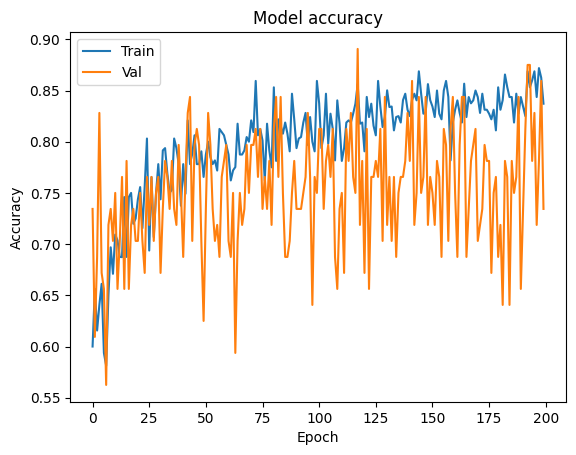

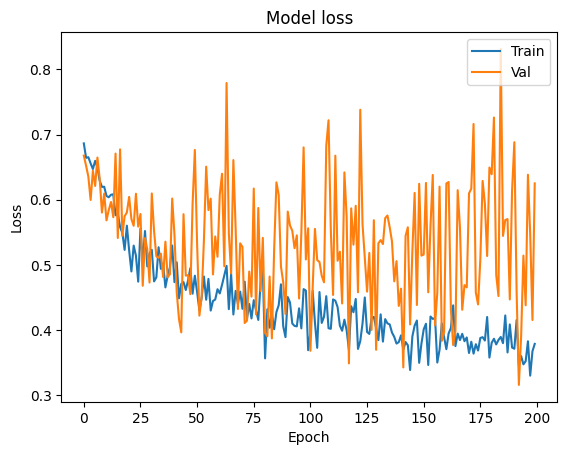

In [20]:
#the first one shows the model's training and validation accuracy and the second plot shows the training and validation loss
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

In [21]:
#saves the trained neural network model to a file named 'grain_count.h5'.
model.save('grain_count.h5')

In [22]:
#loads a previously saved Keras model named 'grain_count.h5' using TensorFlow and assigns it to the variable 'loaded_model.'
from tensorflow import keras
loaded_model = keras.models.load_model('grain_count.h5')

In [23]:
create_directory('mixed')

In [24]:
mixed = r"C:\Users\Lenovo\Downloads\MicrosoftTeams-image (34).png"

In [25]:
pre_process_And_Count(mixed, 'mixed/mixed_')

Number of detected contours 31


In [26]:
import os
from os import listdir
from os.path import isfile, join

In [27]:
# {'broken_rice': 0, 'full_rice': 1}

predict_dir_path='mixed/'
onlyfiles = [f for f in listdir(predict_dir_path) if isfile(join(predict_dir_path, f))]

# predicting images
from tensorflow.keras.preprocessing import image
full = 0 
broken  = 0
for file in onlyfiles:
    img = image.load_img(predict_dir_path+'/'+file, target_size=(img_width, img_height), grayscale=True)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    
    images = np.vstack([x])
    classes = loaded_model.predict(images, batch_size=32)
    classes = classes[0][0]
    if classes == 0:
        broken += 1
    else:
        full += 1
    
print("Total full :",full)
print("Total broken :",broken)

1/1 [==============================] - 0s 107ms/step


C:\Users\Lenovo\anaconda3\Lib\site-packages\keras\utils\image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


1/1 [==============================] - 0s 24ms/step
Total full : 23
Total broken : 8


In [28]:
print("Total rice grains-", (broken+full))
Percent = (broken/(broken+full))*100
if(Percent >= 0 and Percent < 25.0):
    print("Grade A")
elif(Percent >= 25.0 and Percent < 50.0):
    print("Grade B")
elif(Percent >= 50.0 and Percent < 75.0):
    print("Grade C")
elif(Percent >= 75.0 and Percent < 100.0):
    print("Grade D")
else:
    print("Grade E")

Total rice grains- 31
Grade B
